# 1. Set Up and Data Import

In [2]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import datetime
import pytz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb

In [3]:
# Load data
ride_hail_df = pd.read_csv('ride_hail.csv')

# Quick look
print(ride_hail_df.head())

# Drop Unnamed: 0
ride_hail_df.drop(columns=['Unnamed: 0'], inplace=True)
ride_hail_df.head()


   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
# Inspect ride_hail_df
ride_hail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


In [5]:
ride_hail_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


# 2. Data Cleaning and Transformation

In [6]:
# Check for duplicates
ride_hail_df.duplicated().sum()

np.int64(0)

In [7]:
# Some columns of ride_hail_df have missing values
ride_hail_df.isnull().sum()

,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [8]:
# Check the row(s) with null
ride_hail_df[(np.isnan(ride_hail_df['dropoff_longitude'])) | (np.isnan(ride_hail_df['dropoff_latitude']))]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,2013-07-02 03:51:57.0000001,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [9]:
# Drop row with null
ride_hail_df.dropna(inplace=True)

ride_hail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                199999 non-null  object 
 1   fare_amount        199999 non-null  float64
 2   pickup_datetime    199999 non-null  object 
 3   pickup_longitude   199999 non-null  float64
 4   pickup_latitude    199999 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


In [10]:
# Location is in New York, pickup_datetime should be converted to ET
# First convert pickup_datetime to datetime
ride_hail_df['pickup_datetime'] = pd.to_datetime(ride_hail_df['pickup_datetime'], utc = True)

et_zone = pytz.timezone('US/Eastern')

# Convert UTC to Eastern Time
ride_hail_df['pickup_datetime'] = ride_hail_df['pickup_datetime'].dt.tz_convert(et_zone)
ride_hail_df['pickup_datetime'] = ride_hail_df['pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
ride_hail_df['pickup_datetime'] = pd.to_datetime(ride_hail_df['pickup_datetime'])

ride_hail_df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56,-73.994355,40.728225,-73.994710,40.750325,1


In [11]:
# Extract hour, day, day of the year and year from pickup_datetime
ride_hail_df['hour'] = ride_hail_df['pickup_datetime'].dt.hour
ride_hail_df['day'] = ride_hail_df['pickup_datetime'].dt.day_name()
ride_hail_df['day_of_year'] = ride_hail_df['pickup_datetime'].dt.dayofyear
ride_hail_df['year'] = ride_hail_df['pickup_datetime'].dt.year

ride_hail_df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_year,year
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06,-73.999817,40.738354,-73.999512,40.723217,1,15,Thursday,127,2015
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56,-73.994355,40.728225,-73.994710,40.750325,1,16,Friday,198,2009


In [12]:
# Derive the trips_this_hour column
# This is the number of trips in that hour
trip_summary = ride_hail_df.groupby(['year', 'day_of_year', 'hour']).size().reset_index(name='trips_this_hour')
trip_summary.head(2)

,year,day_of_year,hour,trips_this_hour
0,2008,366,20,2
1,2008,366,21,5


In [13]:
# Merge trip_summary with ride_hail_df
ride_hail_df = ride_hail_df.merge(trip_summary, on=['year', 'day_of_year', 'hour'], how='left')
ride_hail_df.head(2)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_year,year,trips_this_hour
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06,-73.999817,40.738354,-73.999512,40.723217,1,15,Thursday,127,2015,6
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56,-73.994355,40.728225,-73.994710,40.750325,1,16,Friday,198,2009,5


In [14]:
# rideX takes up to four passengers, passengers more than 4 will use rideXL
# For this task, we are going to use this to derive vehicle_type column
ride_hail_df['vehicle_type'] = ride_hail_df['passenger_count'].apply(lambda row: 'rideX' if row <= 4 else 'rideXL')
ride_hail_df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_year,year,trips_this_hour,vehicle_type
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06,-73.999817,40.738354,-73.999512,40.723217,1,15,Thursday,127,2015,6,rideX
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56,-73.994355,40.728225,-73.994710,40.750325,1,16,Friday,198,2009,5,rideX


In [15]:
from math import radians, cos, sin, asin, sqrt

# Calculate trip distance based on pickup and dropoff longitude and latitude provided

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

ride_hail_df['trip_distance_km'] = ride_hail_df.apply(lambda row: haversine(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

ride_hail_df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_year,year,trips_this_hour,vehicle_type,trip_distance_km
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06,-73.999817,40.738354,-73.999512,40.723217,1,15,Thursday,127,2015,6,rideX,1.683323
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56,-73.994355,40.728225,-73.994710,40.750325,1,16,Friday,198,2009,5,rideX,2.457590


In [16]:
# Derive booking_time from hour
# This is the time of the day when the ride was booked

def classify_booking_time(hour):
    if 6 <= hour <= 12:
        return "Morning"
    elif 13 <= hour <= 17:
        return "Afternoon"
    elif 18 <= hour <= 21:
        return "Evening"
    else:
        return "Night"

ride_hail_df['booking_time'] = ride_hail_df['hour'].apply(classify_booking_time)

ride_hail_df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_year,year,trips_this_hour,vehicle_type,trip_distance_km,booking_time
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06,-73.999817,40.738354,-73.999512,40.723217,1,15,Thursday,127,2015,6,rideX,1.683323,Afternoon
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56,-73.994355,40.728225,-73.994710,40.750325,1,16,Friday,198,2009,5,rideX,2.457590,Afternoon


In [17]:
# Inspect the updated ride_hail_df
ride_hail_df.describe(include = 'all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,day_of_year,year,trips_this_hour,vehicle_type,trip_distance_km,booking_time
count,199999,199999.000000,199999,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999,199999.000000,199999.000000,199999.000000,199999,199999.000000,199999
unique,199999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,2,NaN,4
top,2010-05-15 04:08:00.00000076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friday,NaN,NaN,NaN,rideX,NaN,Morning
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33164,NaN,NaN,NaN,181718,NaN,66260
mean,NaN,11.359892,2012-03-22 10:38:10.418982144,-72.527631,39.935881,-72.525292,39.923890,1.684543,11.813959,NaN,175.821104,2011.741739,5.237531,NaN,20.855350,NaN
min,NaN,-52.000000,2008-12-31 20:15:22,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000,NaN,1.000000,2008.000000,1.000000,NaN,0.000000,NaN
25%,NaN,6.000000,2010-08-25 04:19:54,-73.992065,40.734796,-73.991407,40.733823,1.000000,7.000000,NaN,86.000000,2010.000000,4.000000,NaN,1.215222,NaN
50%,NaN,8.500000,2012-03-21 16:44:25,-73.981823,40.752592,-73.980093,40.753042,1.000000,12.000000,NaN,168.000000,2012.000000,5.000000,NaN,2.120992,NaN
75%,NaN,12.500000,2013-10-18 22:21:09,-73.967154,40.767158,-73.963658,40.768001,2.000000,17.000000,NaN,268.000000,2013.000000,7.000000,NaN,3.875169,NaN
max,NaN,499.000000,2015-06-30 19:40:39,57.418457,1644.421482,1153.572603,872.697628,208.000000,23.000000,NaN,366.000000,2015.000000,17.000000,NaN,16409.239135,NaN


In [18]:
# Remove records with fare amount of 0 or less and trip distance of 0
# Data will be the tested for outliers before training the algorithms
ride_hail_df = ride_hail_df[(ride_hail_df['fare_amount'] > 0) & (ride_hail_df['trip_distance_km'] > 0)]

ride_hail_df.describe()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_year,year,trips_this_hour,trip_distance_km
count,194347.000000,194347,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000
mean,11.356014,2012-03-24 03:55:43.740870400,-73.853150,40.665377,-73.851503,40.653457,1.684842,11.811126,175.813164,2011.746469,5.237019,21.372420
min,0.010000,2008-12-31 20:15:22,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000,1.000000,2008.000000,1.000000,0.000084
25%,6.000000,2010-08-24 14:44:00,-73.992271,40.736347,-73.991591,40.735214,1.000000,7.000000,86.000000,2010.000000,4.000000,1.281853
50%,8.500000,2012-03-24 07:11:38,-73.982115,40.753250,-73.980537,40.753705,1.000000,12.000000,168.000000,2012.000000,5.000000,2.184508
75%,12.500000,2013-10-22 16:32:00,-73.968392,40.767507,-73.965408,40.768312,2.000000,17.000000,268.000000,2013.000000,7.000000,3.960169
max,499.000000,2015-06-30 19:40:39,57.418457,1644.421482,1153.572603,872.697628,208.000000,23.000000,366.000000,2015.000000,17.000000,16409.239135
std,9.748423,NaN,5.965042,5.588486,8.830298,4.171816,1.388394,5.843126,104.930450,1.859947,2.398579,387.485623


# 3. Exploratory Data Analysis (EDA)

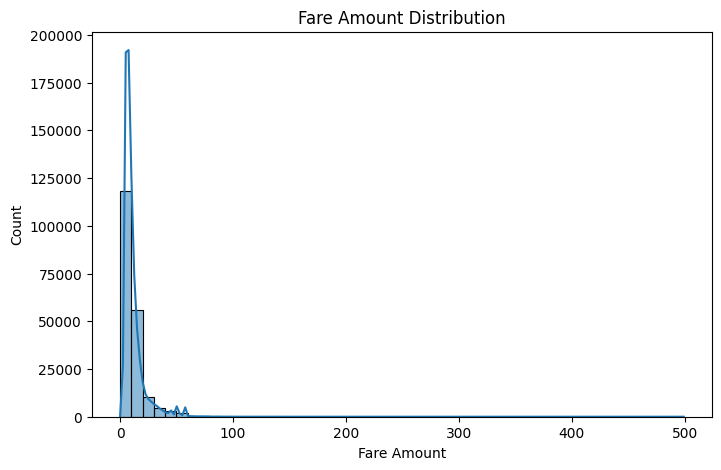

In [19]:
# Fare amount distribution
plt.figure(figsize=(8,5))
sns.histplot(ride_hail_df['fare_amount'], bins=50, kde=True)
plt.xlabel('Fare Amount')
plt.title('Fare Amount Distribution')

plt.show()

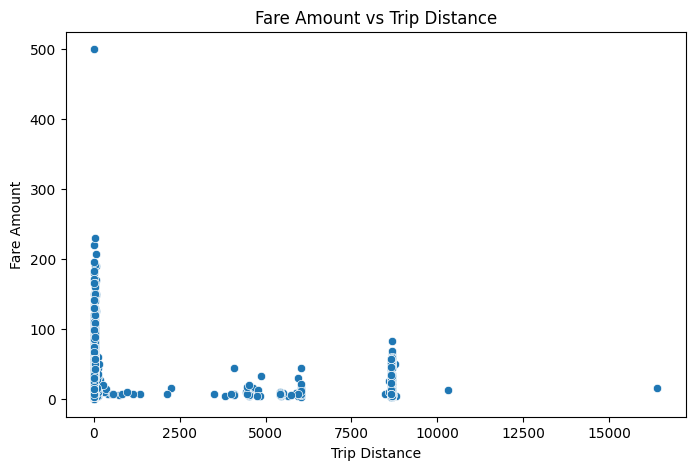

In [20]:
# Fare amount against trip distance
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance_km', y='fare_amount', data=ride_hail_df)
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance')

plt.show()

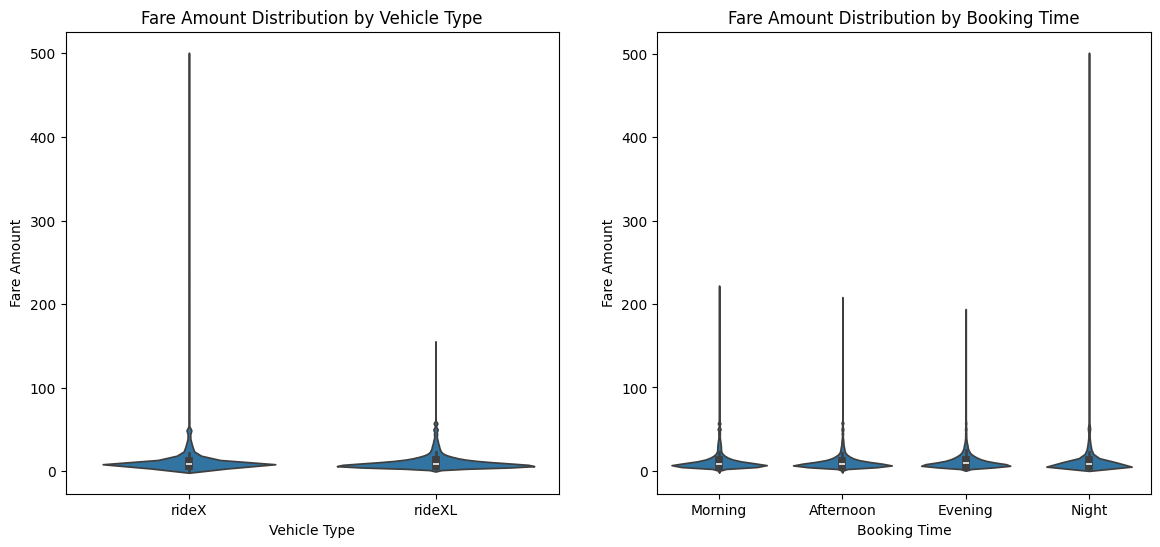

In [21]:
# Fare amount distribution by vehicle type and booking time
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

sns.violinplot(x='vehicle_type', y='fare_amount', data=ride_hail_df, ax=ax1)
sns.violinplot(x='booking_time', y='fare_amount', data=ride_hail_df, order=time_order, ax=ax2)
ax1.set_title('Fare Amount Distribution by Vehicle Type')
ax2.set_title('Fare Amount Distribution by Booking Time')
ax1.set_xlabel("Vehicle Type")
ax1.set_ylabel("Fare Amount")
ax2.set_xlabel("Booking Time")
ax2.set_ylabel("Fare Amount")

plt.show()

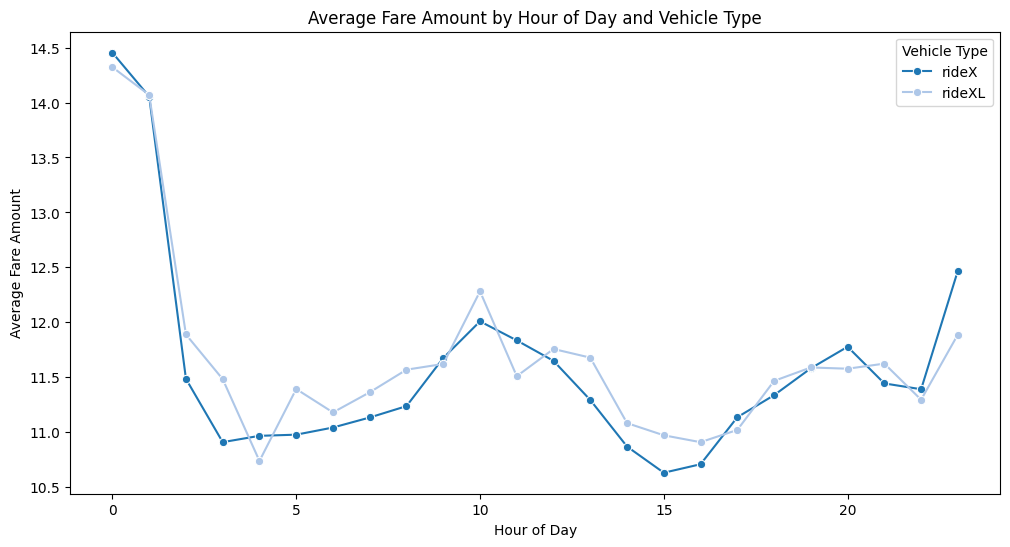

In [22]:
# Average fare amount by hour of day and vehicle type
plt.figure(figsize=(12,6))
sns.lineplot(data=ride_hail_df, x='hour', y='fare_amount', hue='vehicle_type',
             estimator='mean', palette='tab20', errorbar=None, marker='o')
plt.title('Average Fare Amount by Hour of Day and Vehicle Type')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.legend(title='Vehicle Type')

plt.show()

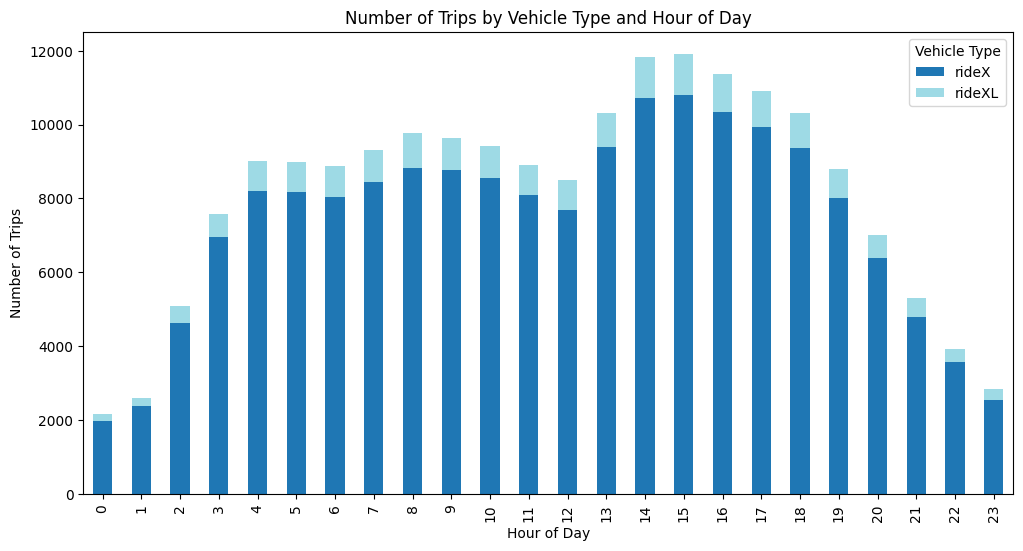

In [23]:
# Number of trips by hour of day and vehicle type
trip_counts = ride_hail_df.groupby(['hour', 'vehicle_type']).size().unstack()

# Create plot
trip_counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title('Number of Trips by Vehicle Type and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend(title='Vehicle Type')

plt.show()

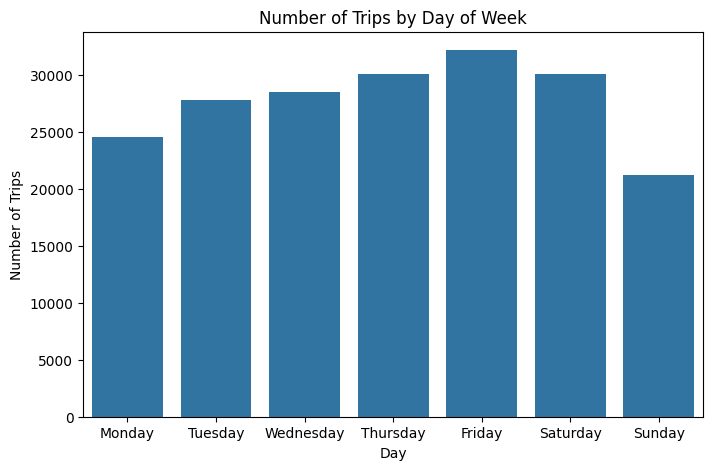

In [24]:
# Number of trips by day of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create plot
plt.figure(figsize=(8,5))
sns.countplot(x='day', data=ride_hail_df, order=day_order)
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Day of Week')

plt.show()

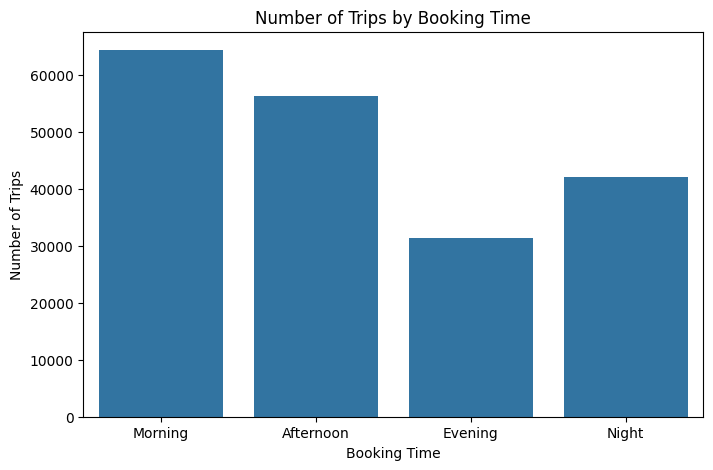

In [25]:
# Number of trips by booking time
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create plot
plt.figure(figsize=(8,5))
sns.countplot(x='booking_time', data=ride_hail_df, order=time_order)
plt.xlabel('Booking Time')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Booking Time')

plt.show()

# 4. Dynamic Pricing

In [26]:
# Derive the surge_factor column using trips_this_hour
high_demand_threshold = np.quantile(ride_hail_df['trips_this_hour'], 0.75)

ride_hail_df['surge_factor'] = np.where(ride_hail_df['trips_this_hour'] > high_demand_threshold,
                                     ride_hail_df['trips_this_hour'] / high_demand_threshold, 1.0)

# Clip surge factor to a reasonable range (say between 1.0x and 1.25x)
ride_hail_df['surge_factor'] = ride_hail_df['surge_factor'].clip(lower = 1.0, upper = 1.25)

# Calculate modified_fare_amount
ride_hail_df['modified_fare_amount'] = ride_hail_df['fare_amount'] * ride_hail_df['surge_factor']

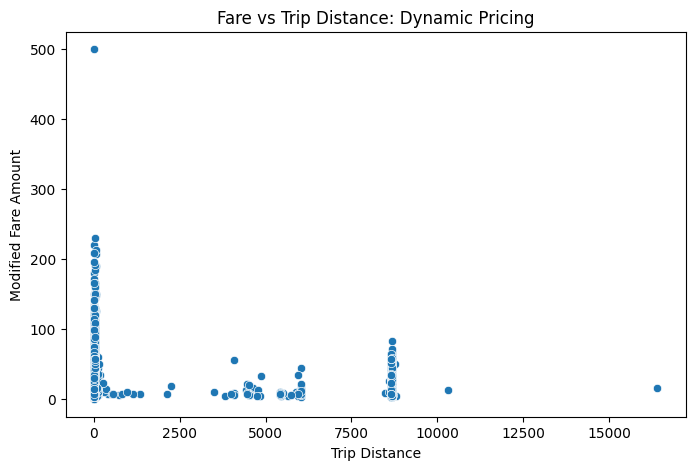

In [27]:
# A look at relationship between modified fare amount and trip distance
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance_km', y='modified_fare_amount', data=ride_hail_df)
plt.xlabel('Trip Distance')
plt.ylabel('Modified Fare Amount')
plt.title('Fare vs Trip Distance: Dynamic Pricing')

plt.show()

# 5. Data Preprocessing

In [28]:
# Columns fare_amount and trip_distance_km still have outliers
# Detect and remove outliers using IQR

# Calculate IQR for fare_amount
Q1_fare = ride_hail_df['fare_amount'].quantile(0.25)
Q3_fare = ride_hail_df['fare_amount'].quantile(0.75)
IQR_fare = Q3_fare - Q1_fare

# Define lower and upper bounds for fare_amount
lower_bound_fare = Q1_fare - 1.5 * IQR_fare
upper_bound_fare = Q3_fare + 1.5 * IQR_fare

# Calculate IQR for trip_distance_km
Q1_dist = ride_hail_df['trip_distance_km'].quantile(0.25)
Q3_dist = ride_hail_df['trip_distance_km'].quantile(0.75)
IQR_dist = Q3_dist - Q1_dist

# Define lower and upper bounds for trip_distance_km
lower_bound_dist = Q1_dist - 1.5 * IQR_dist
upper_bound_dist = Q3_dist + 1.5 * IQR_dist

# Filter out outliers in both fare_amount and trip_distance_km
ride_hail_cleaned = ride_hail_df[
    (ride_hail_df['fare_amount'] >= lower_bound_fare) & (ride_hail_df['fare_amount'] <= upper_bound_fare) &
    (ride_hail_df['trip_distance_km'] >= lower_bound_dist) & (ride_hail_df['trip_distance_km'] <= upper_bound_dist)
]

# Check how many rows were removed
print(f"Original rows: {len(ride_hail_df)}")
print(f"Cleaned rows: {len(ride_hail_cleaned)}")

Original rows: 194347
Cleaned rows: 174477


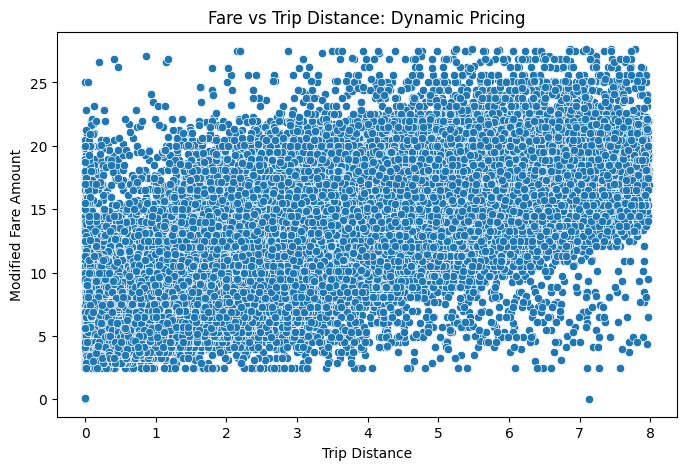

In [29]:
# A look at relationship between modified fare amount and trip distance after removing outliers
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance_km', y='modified_fare_amount', data=ride_hail_cleaned)
plt.xlabel('Trip Distance')
plt.ylabel('Modified Fare Amount')
plt.title('Fare vs Trip Distance: Dynamic Pricing')

plt.show()

In [30]:
# A look at ride_hail_cleaned
ride_hail_cleaned.describe()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_year,year,trips_this_hour,trip_distance_km,surge_factor,modified_fare_amount
count,174477.000000,174477,174477.000000,174477.000000,174477.000000,174477.000000,174477.000000,174477.000000,174477.000000,174477.000000,174477.00000,174477.000000,174477.000000,174477.000000
mean,8.808788,2012-03-12 05:09:18.906515200,-73.921541,40.695781,-73.920011,40.695869,1.682766,11.815042,175.261782,2011.715263,5.26976,2.425848,1.034884,9.117241
min,0.010000,2008-12-31 20:15:22,-75.387785,-74.009697,-75.375315,-74.015750,0.000000,0.000000,1.000000,2008.000000,1.00000,0.000084,1.000000,0.010000
25%,5.700000,2010-08-10 06:49:00,-73.992577,40.737284,-73.991899,40.737087,1.000000,7.000000,85.000000,2010.000000,4.00000,1.209530,1.000000,6.000000
50%,8.000000,2012-03-07 05:46:04,-73.982532,40.753216,-73.981403,40.753810,1.000000,12.000000,167.000000,2012.000000,5.00000,1.979769,1.000000,8.100000
75%,11.000000,2013-10-08 18:15:48,-73.970492,40.766769,-73.968597,40.767492,2.000000,16.000000,268.000000,2013.000000,7.00000,3.234113,1.000000,11.300000
max,22.200000,2015-06-30 19:33:33,40.808425,45.031653,40.831932,45.031598,208.000000,23.000000,366.000000,2015.000000,17.00000,7.977138,1.250000,27.625000
std,3.967730,NaN,2.552716,2.496486,2.552719,2.496506,1.396602,5.797610,105.104381,1.857748,2.39527,1.620495,0.079851,4.178411


In [31]:
# Remove columns not needed for data modeling
ride_hail_cleaned = ride_hail_cleaned.drop(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
                        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count',
                        'day_of_year', 'year', 'surge_factor'], axis = 'columns')
ride_hail_cleaned.head(2)

,hour,day,trips_this_hour,vehicle_type,trip_distance_km,booking_time,modified_fare_amount
0,15,Thursday,6,rideX,1.683323,Afternoon,7.5
1,16,Friday,5,rideX,2.457590,Afternoon,7.7


Perhaps ANOVA test for categorical columns and correlation for numeric columns before encoding.

In [32]:
# One-way ANOVA test for qualitative attributes
import scipy.stats as stats

categorical_cols = ['day', 'vehicle_type', 'booking_time']
target_variable = 'modified_fare_amount'

for col in categorical_cols:
    groups = [group[target_variable].values for name, group in ride_hail_cleaned.groupby(col)]
    f_stat, p_value = stats.f_oneway(*groups)

    print(f'ANOVA results for {col}:')
    print(f'F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}\n')

ANOVA results for day:
F-statistic = 73.68, p-value = 0.0000

ANOVA results for vehicle_type:
F-statistic = 8.59, p-value = 0.0034

ANOVA results for booking_time:
F-statistic = 158.62, p-value = 0.0000



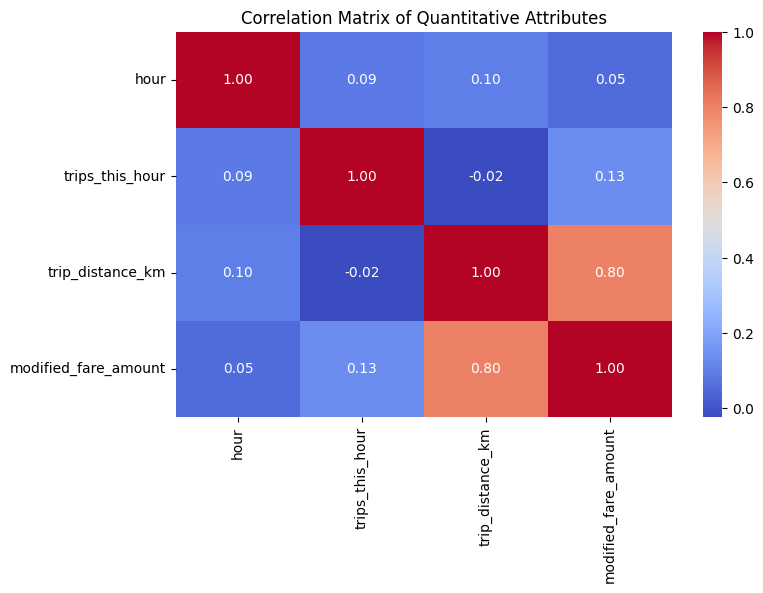

In [33]:
# Correlation between quantitative attributes

correlation_matrix = ride_hail_cleaned[['hour', 'trips_this_hour', 'trip_distance_km', 'modified_fare_amount']].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Quantitative Attributes")

plt.show()

In [34]:
# Encode nominal columns
ride_hail_model = ride_hail_cleaned.copy()
nominal_columns = ['hour', 'day', 'vehicle_type', 'booking_time']
ride_hail_model = pd.get_dummies(ride_hail_model, columns = nominal_columns, drop_first = True, dtype = int)
ride_hail_model.head(2)

,trips_this_hour,trip_distance_km,modified_fare_amount,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,vehicle_type_rideXL,booking_time_Evening,booking_time_Morning,booking_time_Night
0,6,1.683323,7.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,5,2.457590,7.7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Standardize attributes that require it
to_scale = ['trips_this_hour', 'trip_distance_km']
scaler = StandardScaler()
ride_hail_model[to_scale] = scaler.fit_transform(ride_hail_model[to_scale])
ride_hail_model.head(2)

,trips_this_hour,trip_distance_km,modified_fare_amount,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,vehicle_type_rideXL,booking_time_Evening,booking_time_Morning,booking_time_Night
0,0.304868,-0.458210,7.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-0.112622,0.019588,7.7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# How does ride_hail_model look now?
ride_hail_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174477 entries, 0 to 199998
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   trips_this_hour       174477 non-null  float64
 1   trip_distance_km      174477 non-null  float64
 2   modified_fare_amount  174477 non-null  float64
 3   hour_1                174477 non-null  int64  
 4   hour_2                174477 non-null  int64  
 5   hour_3                174477 non-null  int64  
 6   hour_4                174477 non-null  int64  
 7   hour_5                174477 non-null  int64  
 8   hour_6                174477 non-null  int64  
 9   hour_7                174477 non-null  int64  
 10  hour_8                174477 non-null  int64  
 11  hour_9                174477 non-null  int64  
 12  hour_10               174477 non-null  int64  
 13  hour_11               174477 non-null  int64  
 14  hour_12               174477 non-null  int64  
 15  hour_

# 6. Model Building

In [37]:
# Define features and target
X = ride_hail_model.drop(['modified_fare_amount'], axis = 'columns')
y = ride_hail_model['modified_fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

### Linear Regression

In [38]:
# Create and fit the simple linear regression model
slr_model = LinearRegression()
slr_model.fit(X_train, y_train)

# Make prediction with test data
y_pred_slr = slr_model.predict(X_test)

# Calculate R-squared and mean squared error for evaluation
slr_r2 = r2_score(y_test, y_pred_slr)
slr_rmse = root_mean_squared_error(y_test, y_pred_slr)

print(f"Simple Linear Regression:")
print(f"R-squared: {slr_r2:.4f}, RMSE: {slr_rmse:.4f}")

Simple Linear Regression:
R-squared: 0.6748, RMSE: 2.3957


### Random Forest Regressor

In [39]:
# Define formula for tuning the model
def rf_tuning(d):
  model = RandomForestRegressor(max_depth=d, random_state = 123)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rf_r2 = r2_score(y_test, y_pred)
  rf_rmse = root_mean_squared_error(y_test, y_pred)
  return rf_r2, rf_rmse

#Tuning the model
rforest_result = pd.DataFrame({'d':np.arange(1, 17, 2)})

rforest_result['R-Squared'] = rforest_result['d'].apply(lambda d: rf_tuning(d)[0])
rforest_result['RMSE'] = rforest_result['d'].apply(lambda d: rf_tuning(d)[1])

rforest_result

# Optimal max_depth = 11

,d,R-Squared,RMSE
0,1,0.473901,3.047104
1,3,0.652294,2.477191
2,5,0.684262,2.360570
3,7,0.691265,2.334245
4,9,0.694300,2.322745
5,11,0.694725,2.321130
6,13,0.692586,2.329247
7,15,0.688540,2.344522


### XGBoost Regressor

In [40]:
# Define formula for tuning the model
def xgb_tuning(d):
  model = xgb.XGBRegressor(n_estimators=100, max_depth=d, random_state = 123)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  xgb_r2 = r2_score(y_test, y_pred)
  xgb_rmse = root_mean_squared_error(y_test, y_pred)
  return xgb_r2, xgb_rmse

# Tuning the model
xgb_result = pd.DataFrame({'d':np.arange(1, 10)})

xgb_result['R-Squared'] = xgb_result['d'].apply(lambda d: xgb_tuning(d)[0])
xgb_result['RMSE'] = xgb_result['d'].apply(lambda d: xgb_tuning(d)[1])

xgb_result

# Optimal max_depth = 4

,d,R-Squared,RMSE
0,1,0.687472,2.348540
1,2,0.697685,2.309846
2,3,0.700417,2.299387
3,4,0.700627,2.298579
4,5,0.699697,2.302149
5,6,0.697033,2.312338
6,7,0.692899,2.328060
7,8,0.687472,2.348542
8,9,0.680739,2.373705


# 7. Feature Importance

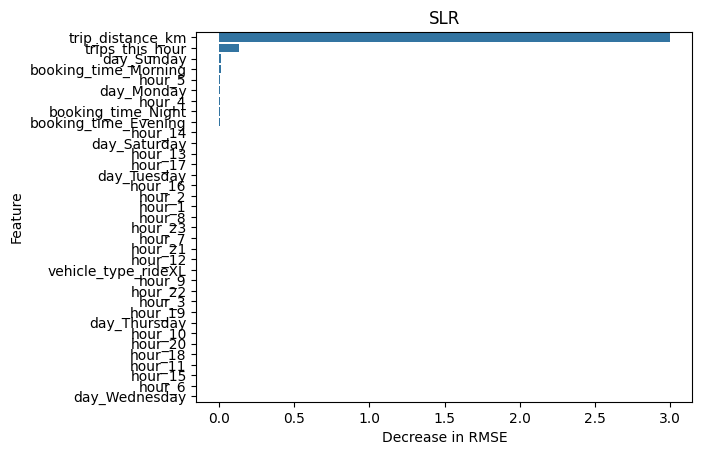

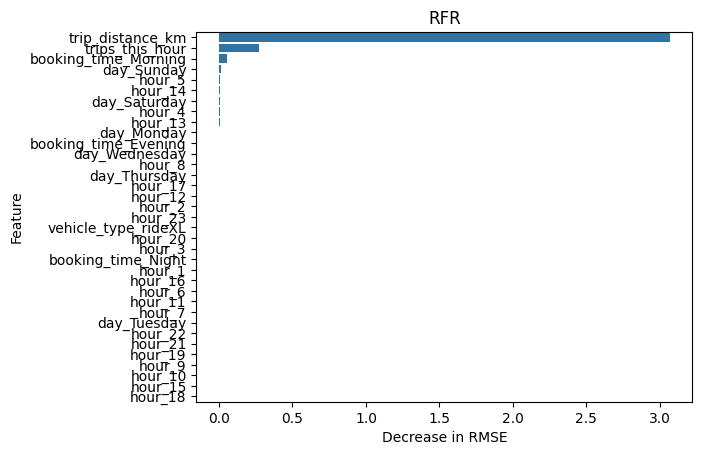

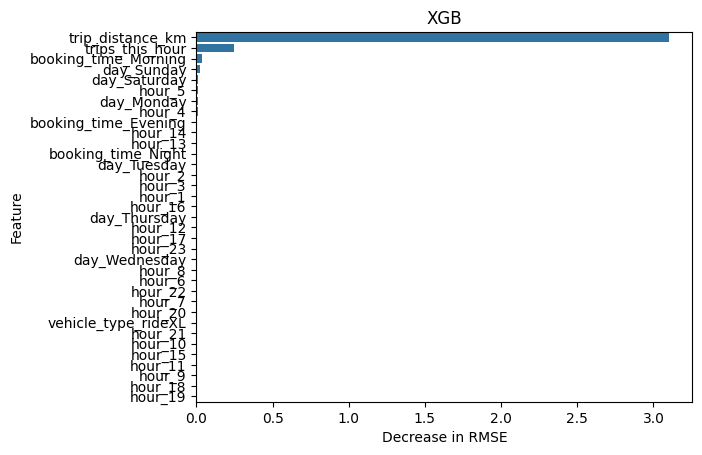

In [41]:
# Feature importance from all models using permutation_importance
all_models = [
    ('SLR', LinearRegression()),
    ('RFR', RandomForestRegressor(max_depth = 11, random_state = 123)),
    ('XGB', xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state = 123))
]

for name, model in all_models:
        md = model.fit(X_train, y_train)
        result = permutation_importance(md, X_test, y_test, scoring = 'neg_root_mean_squared_error', n_repeats = 10 , random_state = 123)
        feature_imp = pd.Series(result.importances_mean,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Decrease in RMSE')
        plt.ylabel('Feature')
        plt.title(name)

        plt.show()

The distance of the ride is the main predictor. Also, demand for trips also contributes. Excellent

# 8. Final Model

In [42]:
# XGB Regressor gave the best result in terms of r2 and rmse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle

ride_hail_model = ride_hail_cleaned.copy()

# Preprocess data
X = ride_hail_model.drop(['modified_fare_amount'], axis = 'columns')
y = ride_hail_model['modified_fare_amount']

nominal_columns = ['hour', 'day', 'vehicle_type', 'booking_time']
to_scale = ['trips_this_hour', 'trip_distance_km']

nominal_transformer = OneHotEncoder(drop='first', dtype=int, handle_unknown='ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('nom', nominal_transformer, nominal_columns),
        ('scale', scaler, to_scale)
    ])

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state = 123))
])

# Split data and fit defined pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

pipeline.fit(X_train, y_train)

# Save the pipeline to a file
with open('dynamic_pricing_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

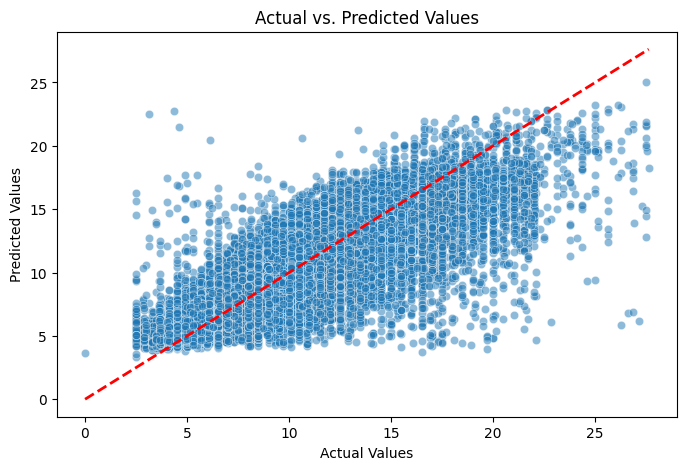

In [43]:
# Compare predictions and actual values
y_pred = pipeline.predict(X_test)

# Create scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# Add perfect prediction line
max_val = y_test.max()
min_val = y_test.min()
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.show()

In [44]:
# Test the model

# Example input data
input_data = pd.DataFrame([{
    'trips_this_hour': 16,
    'trip_distance_km': 6.5,
    'hour': 14,
    'day': 'Friday',
    'vehicle_type': 'rideXL',
    'booking_time': classify_booking_time(16)
}])

# Predict fare
predicted_fare = pipeline.predict(input_data)[0]
print(predicted_fare)

21.044611
